# **Fast Fourier Transform Forecasting Model (FFT)**
**Discrete Fourier Transform (DFT)** is the discrete version of the Fourier Transform (FT) that transforms a signal (or discrete sequence) from the time domain representation to its representation in the frequency domain.

The **Fast Fourier Transform (FFT)** is an optimized algorithm for the implementation of the "Discrete Fourier Transformation" (DFT). A signal is sampled over a period of time and divided into its frequency components.

https://towardsdatascience.com/fast-fourier-transform-937926e591cb 
https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft 

**Forecasting** is one of the process of predicting the future based on past and present data. Most of the forecasting problem associated with time series data (i.e. what is the sale of product A next month).

https://towardsai.net/p/machine-learning/seasonality-detection-with-fast-fourier-transform-fft-and-python 

# Installing Darts Library and Regraded Version of Matplotlib
Could not use Darts Library with the current version of Matplotlib - 3.5.3

Had to degrade to version - 3.1.3

https://stackoverflow.com/questions/64862818/cannot-import-name-png-from-matplotlib

In [ ]:
! pip install darts
! pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 9.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 569 kB 57.8 MB/s 
     |████████████████████████████████| 708 kB 65.1 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 37.2 MB/s 
     |████████████████████████████████| 11.2 MB 43.8 MB/s 
     |████████████████████████████████| 1.8 MB 47.4 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 1.6 MB 48.7 MB/s 
     |████████████████████████████████| 965 kB 48.1 MB/s 
     |████████████████████████████████| 529 kB 68.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 7.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


# Necessary Imports for the Project

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values
from darts.datasets import TemperatureDataset, AirPassengersDataset, EnergyDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


# Temperature Dataset



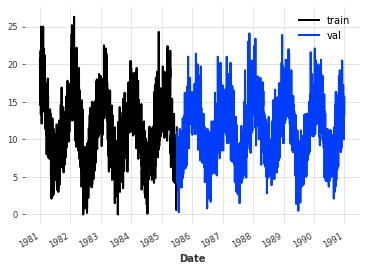

In [ ]:
ts = TemperatureDataset().load()
# Constructing TimeSeries instances for training and validation
train, val = ts.split_after(pd.Timestamp("19850701"))
train.plot(label="train")
val.plot(label="val")

# Basic FFT model

MAE: 3.0995766932270916


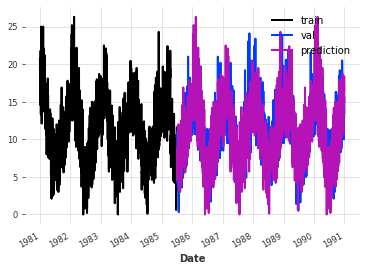

In [ ]:
model = FFT(nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")
print("MAE:", mae(pred_val, val))

The plot above shows us that a simple DFT (Discrete Fourier Transform) with a random train-test split will most likely lead to bad results. Upon closer inspection we can see that the prediction (in purple) simply repeats the training set (blue). This is the standard behavior of the DFT, and by itself it is quite useless, since repeating our training set could be done much more efficiently. 

Three improvements were made to this approach.

# Improvement 1: Crop the training set

The first improvement consists of cropping the training set before feeding it to the FFT algorithm such that the first timestamp in the cropped series matches the first timestamp to be predicted in terms of seasonality, i.e. it has the same month, day, weekday, time of day, etc. 

We could achieve this by passing the optional argument required_matches to the FFT constructor that explicitly tells our model which timestamp attributes are relevant. 

But actually, if we don’t set it manually, the model will attempt to automatically find the pd.Timestamp attributes that are relevant and crop the training set accordingly.

MAE: 5.424526892430279


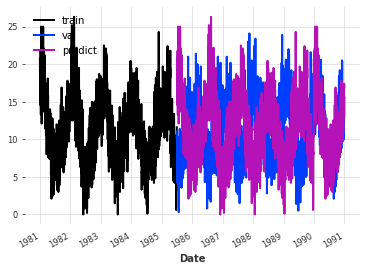

In [ ]:
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="predict")
print("MAE:", mae(pred_val, val))

We see that the results look like the seasonality of the predictions nicely aligns with the seasonality of the validation set. 

However, we are still just repeating the training set, including all of the noise. Looking at the error we can see that this is still a pretty bad forecast.

# Improvement 2: Filtering out low-amplitude waves
The decomposition of the DFT into the frequency domain allows us to selectively filter out waves with low amplitudes. This allows us to keep strong seasonal trends while discarding some noise. 

This is achieved in the FFT model by passing the optional argument nr_freqs_to_keep. This argument represents the total number of frequencies that will be kept. 

For instance, if a value of 20 is passed, only the 20 frequencies with the highest amplitudes will be utilized. The default value is set to 10.

MAE: 2.2941917142812893


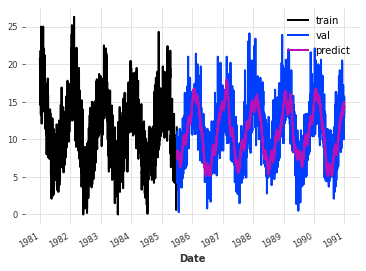

In [ ]:
model = FFT(nr_freqs_to_keep=20)
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="predict")
print("MAE:", mae(pred_val, val))

We get a signal that is less noisy. Depending on the data set, this might be a better forecast. 

Looking at the error metric, we can see that this model performs significantly better than the previous models.



# Air Passengers Dataset

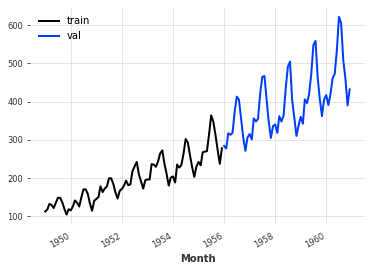

In [ ]:
ts_2 = AirPassengersDataset().load()
train, val = ts_2.split_after(pd.Timestamp("19551201"))
train.plot(label="train")
val.plot(label="val")

**Basic FFT Model on Air Passengers Dataset**

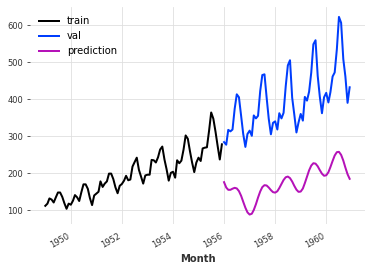

In [ ]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

Our model fails completely at incorporating the upward trend. Due to the trend, our model also fails to recognize the monthly seasonality.

# Improvement 3: Detrending
This problem can be solved by setting the optional trend argument to either ‘poly’ or ‘exp’, which fits a polynomial or exponential funtion to the data and subtracts it before moving on to DFT. 

When predicting, the trend is added again. 

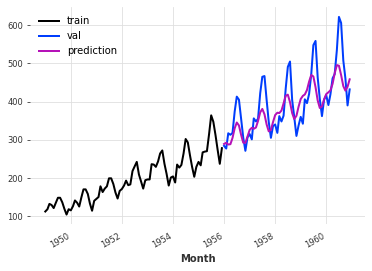

In [ ]:
model = FFT(trend="poly")
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

# Hourly Nuclear Energy Generation Dataset

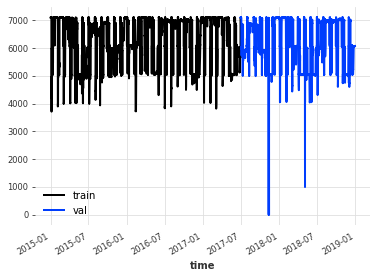

In [ ]:
ts_3 = EnergyDataset().load()
ts_3 = fill_missing_values(ts_3, "auto")
ts_3 = ts_3["generation nuclear"]
train, val = ts_3.split_after(pd.Timestamp("2017-07-01"))
train.plot(label="train")
val.plot(label="val")

# Comparing Performance of FFT model with Others

In [ ]:
models = [AutoARIMA(), ExponentialSmoothing(), Theta(), FFT()]

for model in models:
    model.fit(train)
    pred_val = model.predict(len(val))
    print(str(model) + " MAE: " + str(mae(pred_val, val)))

Auto-ARIMA MAE: 956.1953089418552
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 MAE: 1673.579020435626
Theta(2) MAE: 944.0038491197353
FFT(nr_freqs_to_keep=10, trend=None) MAE: 643.337489093281


MAE - MEAN ABSOLUTE ERROR

The FFT model outperforms all of the others (at least with their default parameters). 

Granted, this dataset was specifically chosen because of its highly seasonal nature. 